# The Data Incubator Project Proposal #

As my TDI project I’d like to propose a tool to explore the relationship of Airbnb listings with some major key features of their surroundings.

This application will take in data from the publicly available Inside Airbnb project, and cross-reference it with other datasets, such as the location of historic/touristic landmarks, parks, shops, crime records and others.

The data can be used to predict in which locations new Airbnb listings are likely to appear, through a simple density estimation that assigns a negative weight to features such as crime counts and positive weights to features such as presence of touristic attractions or other elements of interest (parks, stores, etc.).

Since zones with a high density of listings will likely correlate with a larger tourist influx, the model can also be used to examine the dynamics of tourism within a city. This can be done for instance by converting the average review rate of listings into an estimated booking parameter, and thus estimate the occupancy.

A Machine Learning model can then be set up to predict the (average) review score of future listings based on all the other features. By weighting the kernel density estimation of predicted future listings by the predicted score, we have a model that can estimate the influx of tourists in each part of the city.

This could also be correlated with other features such as weather data, data relative to live events such as concerts, and others, to estimate queues or to predict possible zones with critical densities of tourists.

This analysis can be of use to hotels who want to understand how the competition is likely to evolve, or to Airbnb renters looking for the best location for a new listing, as well as to Airbnb users who want to find the best location given some parameters of interest. It can also be of service to the municipality, to better understand the future dynamics of tourism in the city.

##  Initial data analysis for Chicago City data:  ##

We'll start by loading and preparing the datasets.
The sample datasets used here have been downloaded from various places:
 - Airbnb listings came from the Inside Airbnb datasets [http://insideairbnb.com/get-the-data.html]
 - Other datasets came from the Chicago Data Portal [https://data.cityofchicago.org/]
 
Then we will produce a map of the features, and give a first indicative prediction by using a kernel density estimate.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium as fl
from scipy.stats import gaussian_kde

#### We start by using only three datasets:
 - Airbnb listings
 - Historic/Touristic landmarks
 - Criminal events (arrests)

In [47]:
airbnbs_full = pd.read_csv('listings.csv', index_col=0)
crimes_full = pd.read_csv('Crimes_-_2017.csv', index_col=0)
landmarks_full = pd.read_csv('Individual_Landmarks_-_Map.csv', index_col=0)

In [48]:
airbnbs_full = airbnbs_full.rename(columns={'latitude':'Latitude', 'longitude':'Longitude'})
landmarks_full = landmarks_full.rename(columns={'LATITUDE':'Latitude', 'LONGITUDE':'Longitude'})
arrests_full = crimes_full[crimes_full['Arrest']==True]

airbnbs = airbnbs_full.filter(['Latitude','Longitude'], axis=1).dropna()
arrests = arrests_full.filter(['Latitude','Longitude'], axis=1).dropna()
landmarks = landmarks_full.filter(['Latitude','Longitude'], axis=1).dropna()

#airbnbs.to_csv('clean_ds/airbnbs.csv')
#crimes.to_csv('clean_ds/crimes.csv')
#landmarks.to_csv('clean_ds/landmarks.csv')

In [49]:
datasets = {
    'airbnbs':[airbnbs],
    'arrests':[arrests],
    'landmarks':[landmarks]
}

### Next we can map the features using Folium, to see how they are spatially distributed.

### Note:
Some plots exceed the data rate in this notebook. See the file "Map.html" in the Airbnb repository for the full map.

In [50]:
airbnbs_lat = list(airbnbs["Latitude"])
airbnbs_lon = list(airbnbs["Longitude"])

landmarks_lat = list(landmarks["Latitude"])
landmarks_lon = list(landmarks["Longitude"])

#arrests_lat = list(arrests["Latitude"])
#arrests_lon = list(arrests["Longitude"])

Here is a map with the location of Airbnb listings:

In [45]:
map_a = fl.Map(location=[41.9,-87.65], zoom_start=12, tiles='Stamen Toner')
fg_a = fl.FeatureGroup(name="Airbnbs")

for lt,ln in zip(airbnbs_lat,airbnbs_lon):
    fg_a.add_child(fl.CircleMarker(location=[lt,ln], radius=2, popup=fl.Popup(
    "Airbnb listing", parse_html=True), color="blue"))


map.add_child(fg_a)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Location of landmarks:

In [44]:
map_l = fl.Map(location=[41.85,-87.6], zoom_start=12)
fg_l = fl.FeatureGroup(name="Landmarks")

for lt,ln in zip(landmarks_lat,landmarks_lon):
    fg_l.add_child(fl.CircleMarker(location=[lt,ln], radius=3, popup=fl.Popup(
    "Landmark", parse_html=True), color="green"))

map_l.add_child(fg_l)
map_l

In [ ]:
#tiles="Mapbox Bright"
#tiles='Stamen Toner'

### Now we sketch a prediction by using the gaussian_kde from scipy.stats

The gaussian_kde produces a kernel density estimate using a Gaussian kernel. We can map the three features into kde heatmaps to better understand how the various densities are spatially distributed. Then, we can produce a first estimate prediction of the most likely locations for new Airbnb listings by assigning a negative weight to the features we want to avoid and a positive weight to features we want near.

In [19]:
%matplotlib inline

In [57]:
def kde_fct(lon, lat, bandwidth):
    kernel = gaussian_kde((lon, lat), bw_method=bandwidth)

    return kernel


def kde_map(lon_vec, lat_vec, kernel):
    X, Y = np.meshgrid(lon_vec, lat_vec)
    gridpoints = np.vstack([X.ravel(), Y.ravel()])
    Z = kernel(gridpoints)

    return Z / np.std(Z)


lonmin = -88
lonmax = -87.5
latmin = 41.65
latmax = 42.05
npts = 50
bandwidth = 0.3

x = np.linspace(lonmin, lonmax, npts)
y = np.linspace(latmin, latmax, npts)

X, Y = np.meshgrid(x, y, indexing='ij')
positions = np.vstack([X.ravel(), Y.ravel()])

These are the feature plots:

Text(0.5,1,'landmarks')

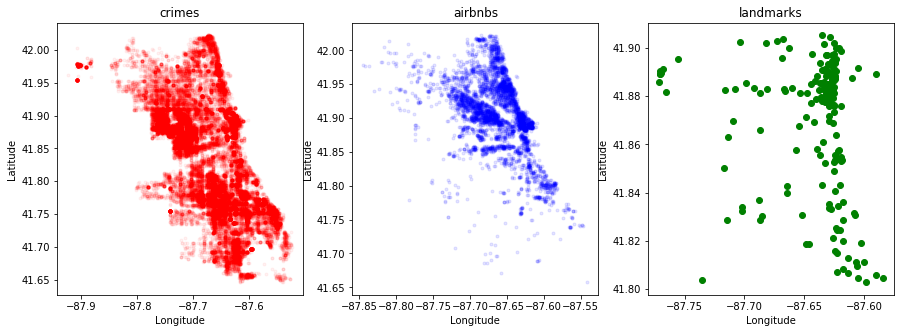

In [53]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax1_x, ax1_y = datasets['arrests'][0]['Longitude'], datasets['arrests'][0]['Latitude']
ax1.plot(ax1_x, ax1_y, '.', color='red', alpha=0.05, label = 'crimes')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('crimes')

ax2_x, ax2_y = datasets['airbnbs'][0]['Longitude'], datasets['airbnbs'][0]['Latitude']
ax2.plot(ax2_x, ax2_y, '.', color='blue', alpha=0.1, label = 'airbnbs')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('airbnbs')

ax3_x, ax3_y = datasets['landmarks'][0]['Longitude'], datasets['landmarks'][0]['Latitude']
ax3.plot(ax3_x, ax3_y, 'o', color='green', label = 'landmarks')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.set_title('landmarks')

And these are the heatmaps:

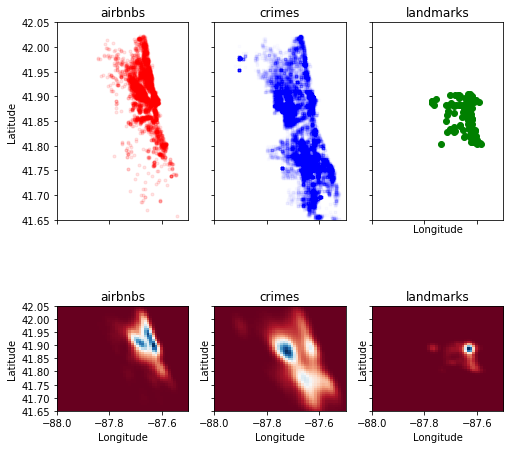

In [55]:
for key in datasets:
    datasets[key].append(kde_fct(
            datasets[key][0]['Longitude'],
            datasets[key][0]['Latitude'],
            bandwidth))

for key in datasets:
    datasets[key].append(kde_map(x, y, datasets[key][1]))
    
    
f, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(8,8), sharex=True, sharey=True)
ax1_x, ax1_y = datasets['airbnbs'][0]['Longitude'], datasets['airbnbs'][0]['Latitude']
ax1.plot(ax1_x, ax1_y, '.', color='red', alpha=0.1, label = 'airbnbs')
ax3.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('airbnbs')

ax2_x, ax2_y = datasets['arrests'][0]['Longitude'], datasets['arrests'][0]['Latitude']
ax2.plot(ax2_x, ax2_y, '.', color='blue', alpha=0.01, label = 'crimes')
ax2.set_title('crimes')

ax3_x, ax3_y = datasets['landmarks'][0]['Longitude'], datasets['landmarks'][0]['Latitude']
ax3.plot(ax3_x, ax3_y, 'o', color='green', label = 'landmarks')
ax3.set_title('landmarks')

kde_plot(x, y, datasets['airbnbs'][-1], 'airbnbs', ax4)
kde_plot(x, y, datasets['arrests'][-1], 'crimes', ax5)    
kde_plot(x, y, datasets['landmarks'][-1], 'landmarks', ax6)

(Note the small extension of landmarks: this analysis is to be considered only preliminary)

If our model assumes that new Airbnbs listings are more likely to appear in zones with a low density of criminal events, low density of existing Airbnb lisings, but high density of touristic landmarks, we obtain a prediction heatmap of the following form:

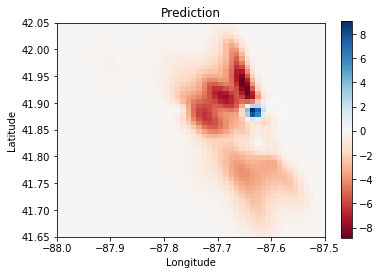

In [58]:
map_df = pd.DataFrame({
        'crime':-1*datasets['arrests'][-1],
        'airbnb':-1*datasets['airbnbs'][-1],
        'landmark':datasets['landmarks'][-1],
    })
pred_map = map_df.sum(axis=1).values

plt.imshow(
        np.rot90(np.reshape(pred_map, (len(x), len(y))).T),
        cmap=plt.cm.RdBu,
        extent=[min(x), max(x), min(y), max(y)]
    )
plt.axis([min(x), max(x), min(y), max(y)])
plt.title('Prediction')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()

### Learning review scores and tourists influx

One possible next step is to use Machine Learning to learn the review scores of future listings based on the other features, such as location, price, cancellation policy, etc.

We can then correlate the number of tourists that will visit each part of the city with the density of listings, weighted by their score, and the density of other features such as landmarks, parks, venues, etc.
This model can be realized using kde maps as before: the main difference is that the score weight is now assigned from the prediction of a Linear Regressor (or K-Neighbours, or other).

In this way we can predict heatmaps of tourists influx in the various parts of the city.